In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # For all our visualization needs.

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import scipy as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc, confusion_matrix, classification_report, precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss

In [3]:
data = pd.read_csv('../data/processed/preprocessed.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800505 entries, 0 to 800504
Data columns (total 84 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         800505 non-null  int64  
 1   msno                               800505 non-null  object 
 2   is_churn                           800505 non-null  int64  
 3   city                               800505 non-null  float64
 4   registered_via                     800505 non-null  float64
 5   registered_year                    800505 non-null  float64
 6   change_in_payment_method           800505 non-null  int64  
 7   total_transaction                  800505 non-null  int64  
 8   max_payment_method                 800505 non-null  int64  
 9   avg_plan_days                      800505 non-null  float64
 10  sum_plan_days                      800505 non-null  int64  
 11  change_in_plan_days                8005

In [5]:
del data['Unnamed: 0']

# 1) XGboost with all feature

In [32]:
X = data.drop(['is_churn','msno'],axis=1)
y= data[['is_churn']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)

In [7]:
param = {
    'n_estimators':[100,150,200],
    'max_depth':[10,12],
    'learning_rate':[0.1,0.5,0.10,0.25],
    'num_leaves':[20,40],
    'alpha':[0.1,0.2,0.5]
}

xgb = XGBClassifier(verbosity=0, tree_method='hist', n_jobs=-1,scoring='roc_auc',objective='binary:logistic')

random_search = RandomizedSearchCV(xgb, n_iter=20, param_distributions=param,n_jobs=-1,cv=5,return_train_score=True,verbose=4)
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=-1,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.2, 0.5],
                                        'learning_rate': [0.1, 0.5, 0.1, 0.25],
                                        'max_depth': [10, 12],
                                        'n_estimators': [100, 150, 200],
                                        'num_leaves': [20, 40]},
                   return_train_score=True, verbose=4)

In [8]:
print("Best Score:" + str(random_search.best_score_))
print("Best Parameters: " + str(random_search.best_params_))

Best Score:0.9704369580437213
Best Parameters: {'num_leaves': 40, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'alpha': 0.5}


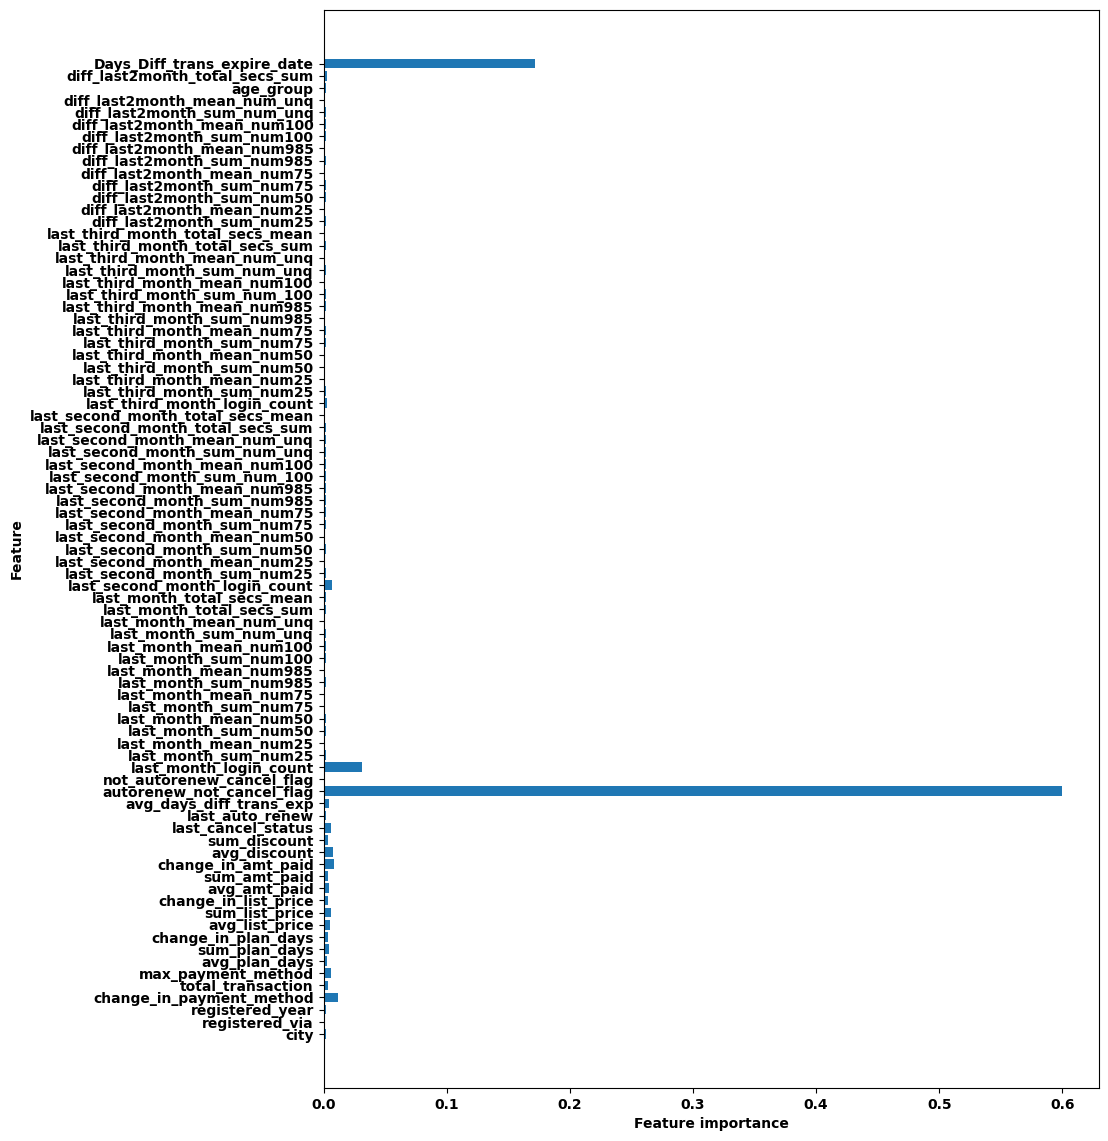

In [12]:

plt.figure(figsize=(10,14))
plt.barh(random_search.best_estimator_.feature_names_in_, random_search.best_estimator_.feature_importances_, align='center')
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [33]:
params = {
 "model_params": {
    "n_estimators": 100,
    "max_depth": 10,
    "learning_rate": 0.1,
    "alpha" : 0.5,
    "objective": "binary:logistic",
    "tree_method": "hist",
    "n_jobs":-1
  },
  "train_params": {
    "eval_metric": [
      "logloss",
      "error",
      "auc",
      "aucpr",
      "map"
    ]
  }
}

In [34]:
#Best parameters used Best Parameters: { 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'alpha': 0.5}

model = XGBClassifier(**params["model_params"])
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_test, y_test)], 
          **params["train_params"])

train_history = model.evals_result()


C:\Users\elave\anaconda3\envs\kkbox\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.60695	validation_0-error:0.02969	validation_0-auc:0.98070	validation_0-aucpr:0.90362	validation_0-map:0.90371	validation_1-logloss:0.60723	validation_1-error:0.03254	validation_1-auc:0.98049	validation_1-aucpr:0.89572	validation_1-map:0.89572
[1]	validation_0-logloss:0.53625	validation_0-error:0.02909	validation_0-auc:0.98132	validation_0-aucpr:0.90789	validation_0-map:0.90796	validation_1-logloss:0.53683	validation_1-error:0.03161	validation_1-auc:0.98087	validation_1-aucpr:0.89878	validation_1-map:0.89893
[2]	validation_0-logloss:0.47739	validation_0-error:0.02881	validation_0-auc:0.98174	validation_0-aucpr:0.91004	validation_0-map:0.91009	validation_1-logloss:0.47824	validation_1-error:0.03157	validation_1-auc:0.98125	validation_1-aucpr:0.90049	validation_1-map:0.90054
[3]	validation_0-logloss:0.42764	validation_0-error:0.02857	validation_0-auc:0.98202	validation_0-aucpr:0.91198	validation_0-map:0.91207	validation_1-logloss:0.42875	validation_1-error:0.031

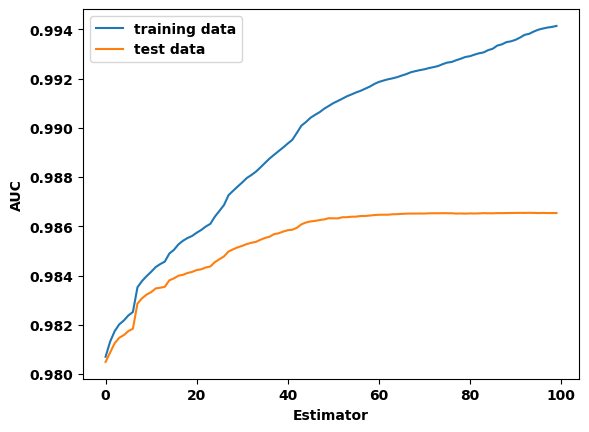

In [37]:
#plot auc from eval_result
plt.plot(np.arange(100), train_history["validation_0"]["auc"], label="training data")
plt.plot(np.arange(100), train_history["validation_1"]["auc"], label="test data")
plt.xlabel('Estimator')
plt.ylabel('AUC')
plt.legend()

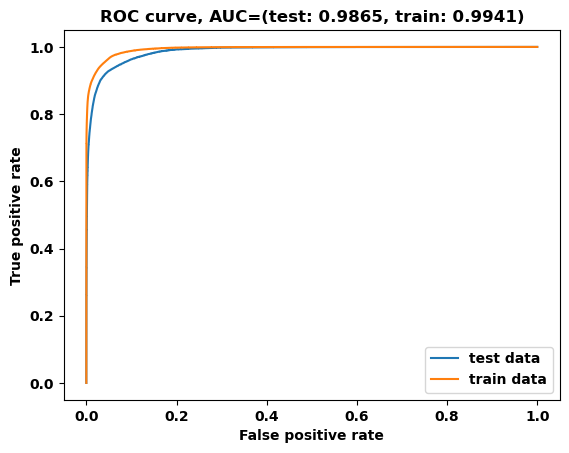

In [26]:
#calculate ROC and plot the curve and check with eval result
y_pred_proba_train = model.predict_proba(X_train)
y_pred_proba_test = model.predict_proba(X_test)

fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test[:, 1])
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train[:, 1])

auc_test = auc(fpr_test, tpr_test)
auc_train = auc(fpr_train, tpr_train)


plt.title(f"ROC curve, AUC=(test: {auc_test:.4f}, train: {auc_train:.4f})")
plt.plot(fpr_test, tpr_test, label="test data")
plt.plot(fpr_train, tpr_train, label="train data")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()

In [23]:
y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)
Accuracy=model.score(X_test,y_test)
print(Accuracy)

[[179408   1963]
 [  3911  14845]]
0.9706486381147971


In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98    181371
           1       0.88      0.79      0.83     18756

    accuracy                           0.97    200127
   macro avg       0.93      0.89      0.91    200127
weighted avg       0.97      0.97      0.97    200127



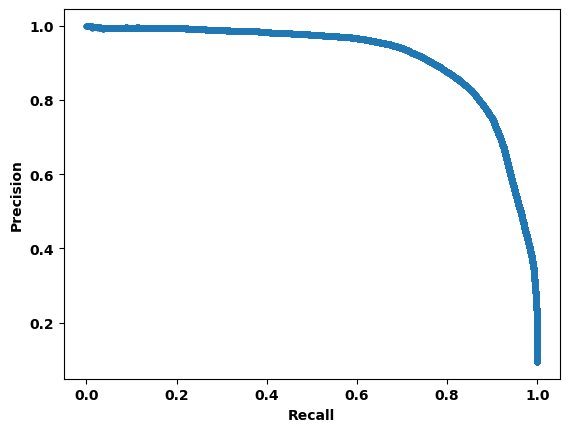

In [31]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_test[:,1])
plt.plot(precision, recall)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

In [35]:
y_pred_proba_train = model.predict_proba(X_train)
y_pred_proba_test = model.predict_proba(X_test)

train_log_loss = log_loss(y_train,y_pred_proba_train)
test_log_loss = log_loss(y_test,y_pred_proba_test)

In [36]:
train_log_loss

0.05325100172952137

In [37]:
test_log_loss

0.07819105991544212

Conclusion for using all features in XGBOOST: 
            Though the metrics look good, using all features might create noise

# 2) Random forest using all feature

In [9]:
#Random Forest

param_dist = {"n_estimators":[100,200,300],
    "max_depth": [3, 5], 
    "max_features": ["auto","sqrt"], 
    "min_samples_split":[2, 5, 10], 
    "bootstrap": [True, False], 
    "criterion": ["gini", "entropy"]} 
# build a classifier 
clf = RandomForestClassifier(n_estimators=50)
# Randomized search
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
    n_iter=8, cv=5, scoring='roc_auc',return_train_score=True,n_jobs=-1) 
random_search.fit(X_train, y_train)


C:\Users\elave\anaconda3\envs\kkbox\Lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(n_estimators=50),
                   n_iter=8, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   return_train_score=True, scoring='roc_auc')

In [10]:
random_search.cv_results_

{'mean_fit_time': array([143.0585422 , 549.76050968, 529.0659411 , 509.07490945,
        756.53098159, 176.46938477, 336.4737782 , 286.74288611]),
 'std_fit_time': array([ 1.73978698,  8.28199314,  4.03517644,  4.21335657,  2.23171481,
         2.54808978,  5.89856548, 15.18502241]),
 'mean_score_time': array([1.33487535, 3.18723626, 3.94908781, 3.97387266, 4.79556012,
        1.42052579, 2.62332983, 1.09927816]),
 'std_score_time': array([0.04200217, 0.07795489, 0.12008822, 0.10734126, 0.13140775,
        0.02060666, 0.13353677, 0.15248725]),
 'param_n_estimators': masked_array(data=[100, 200, 300, 300, 300, 100, 200, 100],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[5, 10, 2, 10, 5, 5, 5, 10],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_arra

In [11]:
print("Best Score:" + str(random_search.best_score_))
print("Best Parameters: " + str(random_search.best_params_))

Best Score:0.9631849518553952
Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}


In [14]:
params={
    "model_params":{'n_estimators': 200, 
                  'min_samples_split': 10, 
                  'max_features': 'sqrt', 
                  'max_depth': 5, 
                  'criterion': 'entropy', 
                  'bootstrap': True,
                'n_jobs':-1},   
}

In [17]:
model = RandomForestClassifier(**params["model_params"])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)
Accuracy=model.score(X_test,y_test)
print(Accuracy)

C:\Users\elave\AppData\Local\Temp\ipykernel_3916\2814994029.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


[[180865    506]
 [ 10784   7972]]
0.9435858230023935


In [18]:
print(classification_report(y_test, y_pred))
# recall for class 1 is very bad in random forest

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    181371
           1       0.94      0.43      0.59     18756

    accuracy                           0.94    200127
   macro avg       0.94      0.71      0.78    200127
weighted avg       0.94      0.94      0.93    200127



In [ ]:
#calculate ROC and plot the curve and check with eval result
y_pred_proba_train = model.predict_proba(X_train)
y_pred_proba_test = model.predict_proba(X_test)

fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test[:, 1])
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train[:, 1])

auc_test = auc(fpr_test, tpr_test)
auc_train = auc(fpr_train, tpr_train)


plt.title(f"ROC curve, AUC=(test: {auc_test:.4f}, train: {auc_train:.4f})")
plt.plot(fpr_test, tpr_test, label="test data")
plt.plot(fpr_train, tpr_train, label="train data")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()

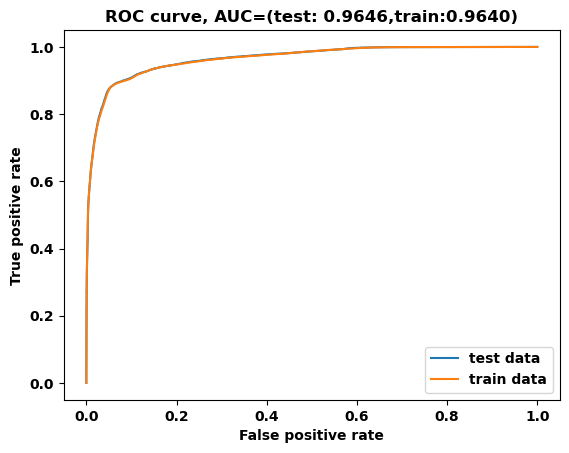

In [19]:
y_pred_proba_train = model.predict_proba(X_train)
y_pred_proba_test = model.predict_proba(X_test)

fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test[:, 1])
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train[:, 1])

auc_test = auc(fpr_test, tpr_test)
auc_train = auc(fpr_train, tpr_train)

plt.title(f"ROC curve, AUC=(test: {auc_test:.4f},train:{auc_train:.4f})")
plt.plot(fpr_test, tpr_test, label="test data")
plt.plot(fpr_train, tpr_train, label="train data")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()

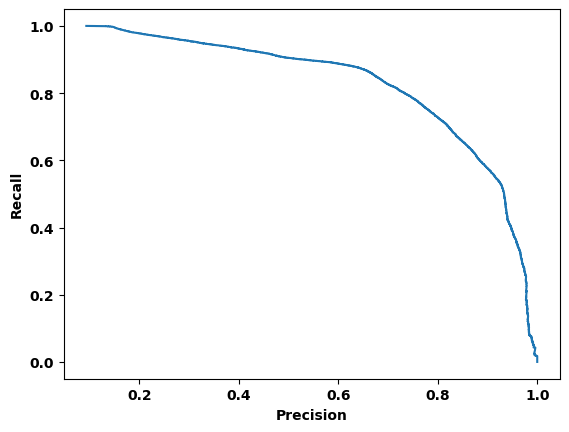

In [23]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_test[:,1])
plt.plot(precision, recall)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

# Conclusion - Clearly XGBoost is better performing -

Recall, ROC_auc are better with XGboost compared to Random forest

# 3) XGBOOST - With Recursive feature elimination (RFECV selected feature)

In [39]:
#optimal number of features from RFECV
# 'max_payment_method', 'avg_amt_paid', 'sum_amt_paid', 'change_in_amt_paid', 'autorenew_not_cancel_flag', 'last_month_login_count', 'last_second_month_login_count', 'last_third_month_login_count', 'autorenew_cancel_flag', 'Days_Diff_trans_expire_date'

X =data[['max_payment_method', 'avg_amt_paid', 'sum_amt_paid', 'change_in_amt_paid', 'autorenew_not_cancel_flag', 'last_month_login_count', 'last_second_month_login_count', 'last_third_month_login_count', 'last_cancel_status', 'Days_Diff_trans_expire_date']]
y= data[['is_churn']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)

In [30]:
param = {
    'n_estimators':[50,100,150,200],
    'max_depth':[3,5,7],
    'learning_rate':[0.01,0.001,0.1,0.2],
    'subsample': [0.5, 0.7, 1],
    'alpha':[0.1,0.2,0.5]
}

xgb = XGBClassifier(verbosity=0, tree_method='hist', n_jobs=-1,scoring='roc_auc',objective='binary:logistic')

random_search = RandomizedSearchCV(xgb, n_iter=20, param_distributions=param,n_jobs=-1,cv=5,return_train_score=True,verbose=4)
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=-1,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.2, 0.5],
                                        'learning_rate': [0.01, 0.001, 0.1,
                                                          0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 150, 200],
                                        'subsample': [0.5, 0.7, 1]},
                   return_train_score=True, verbose=4)

In [31]:
random_search.cv_results_

{'mean_fit_time': array([38.30210624, 29.46887865, 22.13005176, 15.10239792, 11.69422174,
        23.75461082, 17.19788537,  4.92154698, 35.41146207, 18.09717803,
        16.79875703,  4.12897773,  8.52926798,  5.54819865,  5.74572773,
         9.99081836,  9.36427879, 18.65841732, 35.17814412, 16.50493741]),
 'std_fit_time': array([1.78770377, 1.68296412, 1.34059357, 0.95384044, 0.58694981,
        1.46713649, 1.26851782, 0.36920282, 1.50355623, 1.10169864,
        1.02980567, 0.22128748, 0.34550637, 0.34470299, 0.23182012,
        0.68544091, 0.5312554 , 0.86811567, 0.61896033, 1.25385458]),
 'mean_score_time': array([1.47749333, 0.52887864, 0.44848824, 0.35591788, 0.77124147,
        0.682583  , 0.47700238, 0.24740868, 1.31053653, 0.71832085,
        0.61998234, 0.24167857, 0.29510784, 0.40436196, 0.37723179,
        0.41615996, 0.64013591, 0.65701022, 1.25536389, 0.45934243]),
 'std_score_time': array([0.15866632, 0.05703418, 0.03639112, 0.04240345, 0.07012718,
        0.05820797, 

In [32]:
print("Best Score:" + str(random_search.best_score_))
print("Best Parameters: " + str(random_search.best_params_))

Best Score:0.9696374625170593
Best Parameters: {'subsample': 1, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'alpha': 0.2}


In [42]:
params = {
 "model_params": {
    "subsample": 1,
    "n_estimators": 100,
    "max_depth": 7,
    "learning_rate": 0.1,
    "alpha" : 0.2,
    "objective": "binary:logistic",
    "tree_method": "hist",
    "n_jobs":-1
  },
  "train_params": {
    "eval_metric": [
      "logloss",
      "auc"
    ]
  }
}

In [43]:
#Best parameters used Best Parameters: { 'subsample': 1, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'alpha': 0.2}

model = XGBClassifier(**params["model_params"])
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_test, y_test)], 
          **params["train_params"])

train_history = model.evals_result()


[0]	validation_0-logloss:0.60780	validation_0-auc:0.97486	validation_1-logloss:0.60785	validation_1-auc:0.97580
[1]	validation_0-logloss:0.53790	validation_0-auc:0.97517	validation_1-logloss:0.53796	validation_1-auc:0.97624
[2]	validation_0-logloss:0.47968	validation_0-auc:0.97551	validation_1-logloss:0.47980	validation_1-auc:0.97645
[3]	validation_0-logloss:0.43054	validation_0-auc:0.97559	validation_1-logloss:0.43068	validation_1-auc:0.97656
[4]	validation_0-logloss:0.38867	validation_0-auc:0.97564	validation_1-logloss:0.38884	validation_1-auc:0.97660
[5]	validation_0-logloss:0.35267	validation_0-auc:0.97589	validation_1-logloss:0.35290	validation_1-auc:0.97690
[6]	validation_0-logloss:0.32156	validation_0-auc:0.97609	validation_1-logloss:0.32181	validation_1-auc:0.97706
[7]	validation_0-logloss:0.29452	validation_0-auc:0.97636	validation_1-logloss:0.29479	validation_1-auc:0.97730
[8]	validation_0-logloss:0.27093	validation_0-auc:0.97681	validation_1-logloss:0.27123	validation_1-auc:

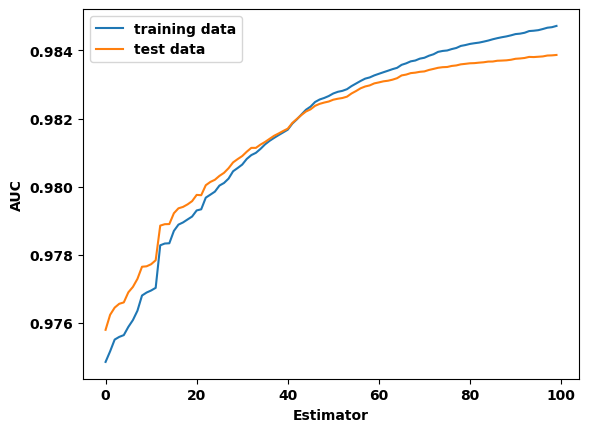

In [35]:
#plot auc from eval_result
plt.plot(np.arange(100), train_history["validation_0"]["auc"], label="training data")
plt.plot(np.arange(100), train_history["validation_1"]["auc"], label="test data")
plt.xlabel('Estimator')
plt.ylabel('AUC')
plt.legend()

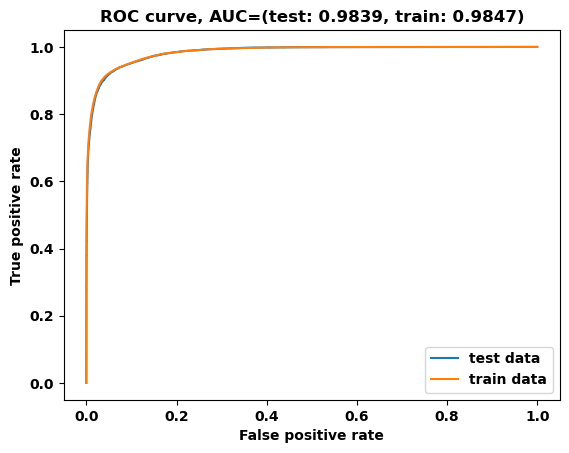

In [36]:
#calculate ROC and plot the curve and check with eval result
y_pred_proba_train = model.predict_proba(X_train)
y_pred_proba_test = model.predict_proba(X_test)

fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test[:, 1])
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train[:, 1])

auc_test = auc(fpr_test, tpr_test)
auc_train = auc(fpr_train, tpr_train)


plt.title(f"ROC curve, AUC=(test: {auc_test:.4f}, train: {auc_train:.4f})")
plt.plot(fpr_test, tpr_test, label="test data")
plt.plot(fpr_train, tpr_train, label="train data")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()

In [37]:
y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)
Accuracy=model.score(X_test,y_test)
print(Accuracy)

[[179453   1918]
 [  4208  14548]]
0.969389437707056


In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98    181371
           1       0.88      0.78      0.83     18756

    accuracy                           0.97    200127
   macro avg       0.93      0.88      0.90    200127
weighted avg       0.97      0.97      0.97    200127



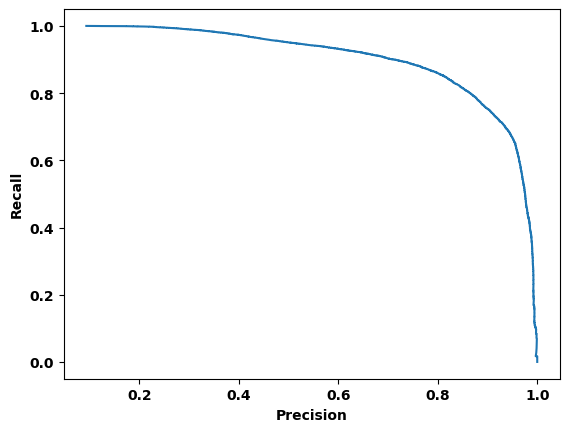

In [39]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_test[:,1])
plt.plot(precision, recall)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

In [44]:
y_pred_proba_train = model.predict_proba(X_train)
y_pred_proba_test = model.predict_proba(X_test)

train_log_loss = log_loss(y_train,y_pred_proba_train)
test_log_loss = log_loss(y_test,y_pred_proba_test)

In [45]:
train_log_loss

0.07954051108778844

In [47]:
test_log_loss

0.08288320349586982

The model looks overfit in AUC curve

# 4) XGBOOST - With Maximum Relevance — Minimum Redundancy (MRMR selected feature)

In [8]:
X = data[['autorenew_not_cancel_flag',
 'diff_last2month_sum_num50',
 'Days_Diff_trans_expire_date',
 'last_cancel_status',
 'avg_plan_days',
 'last_auto_renew',
 'avg_list_price',
 'avg_amt_paid',
 'change_in_payment_method',
 'avg_days_diff_trans_exp',
 'total_transaction',
 'max_payment_method',
 'change_in_amt_paid',
 'diff_last2month_sum_num100',
 'registered_via',
 'change_in_plan_days',
 'diff_last2month_sum_num_unq',
 'city',
 'change_in_list_price',
 'last_month_login_count']]
y= data[['is_churn']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)

In [9]:
param = {
    'n_estimators':[100,150,200],
    'max_depth':[10,12],
    'learning_rate':[0.1,0.5,0.10,0.25],
    'alpha':[0.1,0.2,0.5],
    'gamma':[0.2,0.4],
    'colsample_bytree':[0.5,0.8]
}

xgb = XGBClassifier(verbosity=0, tree_method='hist', n_jobs=-1,scoring='roc_auc',objective='binary:logistic')

random_search = RandomizedSearchCV(xgb, n_iter=20, param_distributions=param,n_jobs=-1,cv=5,return_train_score=True,verbose=4)
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=-1,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.2, 0.5],
                                        'colsample_bytree': [0.5, 0.8],
                                        'gamma': [0.2, 0.4],
                                        'learning_rate': [0.1, 0.5, 0.1, 0.25],
                                        'max_depth': [10, 12],
                                        'n_estimators': [100, 150, 200]},
                   return_train_score=True, verbose=4)

In [10]:
print("Best Score:" + str(random_search.best_score_))
print("Best Parameters: " + str(random_search.best_params_))

Best Score:0.9702254247512906
Best Parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.8, 'alpha': 0.1}


In [12]:
params = {
 "model_params": {
   'n_estimators': 100,
   'max_depth': 10, 
   'learning_rate': 0.1, 
   'gamma': 0.4, 
   'colsample_bytree': 0.8, 
   'alpha': 0.1,
    "objective": "binary:logistic",
    "tree_method": "hist",
    'n_jobs':-1,
    'verbosity':0
  },
  "train_params": {
    "eval_metric": [
      "logloss",
      "auc",
    ]
  }
}

In [13]:
#Best parameters used 

model = XGBClassifier(**params["model_params"])
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_test, y_test)], 
          **params["train_params"])

train_history = model.evals_result()


C:\Users\elave\anaconda3\envs\kkbox\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.60709	validation_0-auc:0.97927	validation_1-logloss:0.60730	validation_1-auc:0.97930
[1]	validation_0-logloss:0.53722	validation_0-auc:0.97975	validation_1-logloss:0.53757	validation_1-auc:0.97970
[2]	validation_0-logloss:0.47832	validation_0-auc:0.98067	validation_1-logloss:0.47885	validation_1-auc:0.98058
[3]	validation_0-logloss:0.42870	validation_0-auc:0.98220	validation_1-logloss:0.42942	validation_1-auc:0.98195
[4]	validation_0-logloss:0.38626	validation_0-auc:0.98247	validation_1-logloss:0.38716	validation_1-auc:0.98213
[5]	validation_0-logloss:0.35014	validation_0-auc:0.98239	validation_1-logloss:0.35122	validation_1-auc:0.98197
[6]	validation_0-logloss:0.31855	validation_0-auc:0.98259	validation_1-logloss:0.31982	validation_1-auc:0.98215
[7]	validation_0-logloss:0.29109	validation_0-auc:0.98274	validation_1-logloss:0.29255	validation_1-auc:0.98223
[8]	validation_0-logloss:0.26738	validation_0-auc:0.98314	validation_1-logloss:0.26901	validation_1-auc:

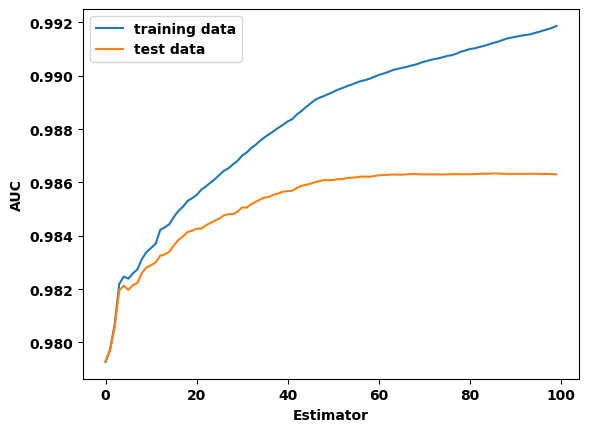

In [14]:
#plot auc from eval_result
plt.plot(np.arange(100), train_history["validation_0"]["auc"], label="training data")
plt.plot(np.arange(100), train_history["validation_1"]["auc"], label="test data")
plt.xlabel('Estimator')
plt.ylabel('AUC')
plt.legend()

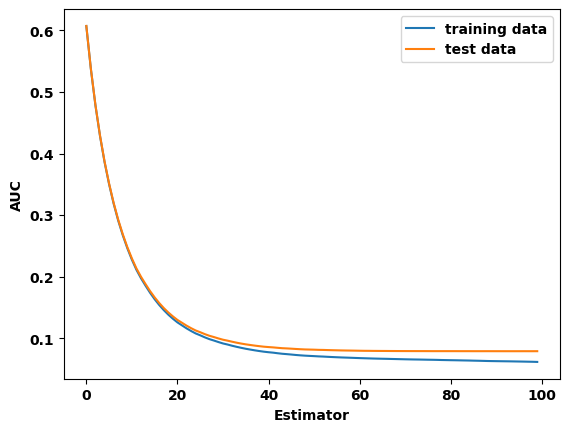

In [15]:
#plot auc from eval_result
plt.plot(np.arange(100), train_history["validation_0"]["logloss"], label="training data")
plt.plot(np.arange(100), train_history["validation_1"]["logloss"], label="test data")
plt.xlabel('Estimator')
plt.ylabel('Logloss')
plt.legend()

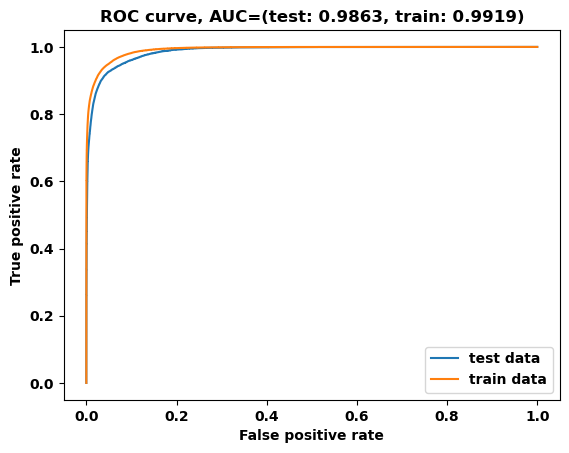

In [16]:
#calculate ROC and plot the curve and check with eval result
y_pred_proba_train = model.predict_proba(X_train)
y_pred_proba_test = model.predict_proba(X_test)

fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test[:, 1])
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train[:, 1])

auc_test = auc(fpr_test, tpr_test)
auc_train = auc(fpr_train, tpr_train)


plt.title(f"ROC curve, AUC=(test: {auc_test:.4f}, train: {auc_train:.4f})")
plt.plot(fpr_test, tpr_test, label="test data")
plt.plot(fpr_train, tpr_train, label="train data")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()

In [17]:
y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)
Accuracy=model.score(X_test,y_test)
print(Accuracy)

[[179384   1987]
 [  3995  14761]]
0.9701089807971938


In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98    181371
           1       0.88      0.79      0.83     18756

    accuracy                           0.97    200127
   macro avg       0.93      0.89      0.91    200127
weighted avg       0.97      0.97      0.97    200127



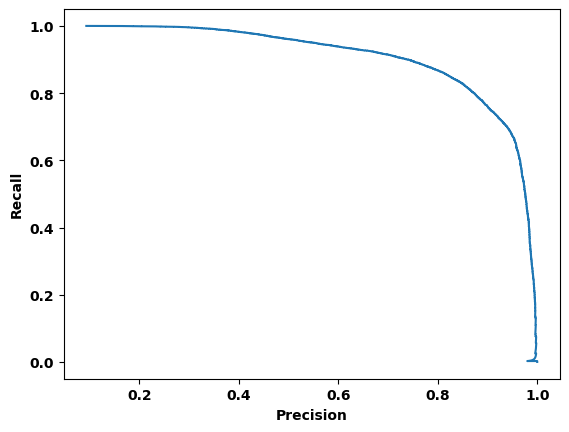

In [19]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_test[:,1])
plt.plot(precision, recall)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

In [29]:
y_pred_proba_train = model.predict_proba(X_train)
y_pred_proba_test = model.predict_proba(X_test)

train_log_loss = log_loss(y_train,y_pred_proba_train)
test_log_loss = log_loss(y_test,y_pred_proba_test)

In [30]:
train_log_loss

0.061526038912654374

In [31]:
test_log_loss

0.0789568906769131

# Conclusion: Log loss is less using MRMR features compared to RFE features. The final model selected is XGBoost with MRMR-selected features